*************start to define Model **************
*************Model Defined **************
Status: Optimal
Optimal Value: 6.0
x_('batch1',_1,_'machine1',_1) = 1.0
x_('batch1',_1,_'machine1',_2) = 1.0
x_('batch1',_2,_'machine1',_5) = 1.0
x_('batch1',_2,_'machine1',_6) = 1.0
x_('batch1',_3,_'machine1',_7) = 1.0
x_('batch1',_3,_'machine1',_8) = 1.0
x_('batch2',_1,_'machine1',_10) = 1.0
x_('batch2',_1,_'machine1',_13) = 1.0
x_('batch2',_1,_'machine1',_15) = 1.0
x_('batch2',_1,_'machine1',_16) = 1.0
x_('batch2',_1,_'machine1',_9) = 1.0
x_('batch2',_1,_'machine2',_1) = 1.0
x_('batch2',_1,_'machine2',_2) = 1.0
x_('batch2',_1,_'machine2',_3) = 1.0
x_('batch2',_1,_'machine2',_4) = 1.0
x_('batch2',_1,_'machine2',_5) = 1.0
x_('batch2',_2,_'machine1',_11) = 1.0
x_('batch2',_2,_'machine1',_19) = 1.0
x_('batch2',_2,_'machine2',_6) = 1.0
x_('batch2',_2,_'machine2',_7) = 1.0
x_('batch3',_1,_'machine1',_14) = 1.0
x_('batch3',_1,_'machine1',_18) = 1.0
x_('batch3',_1,_'machine3',_1) = 1.0
x_('batch3',_1

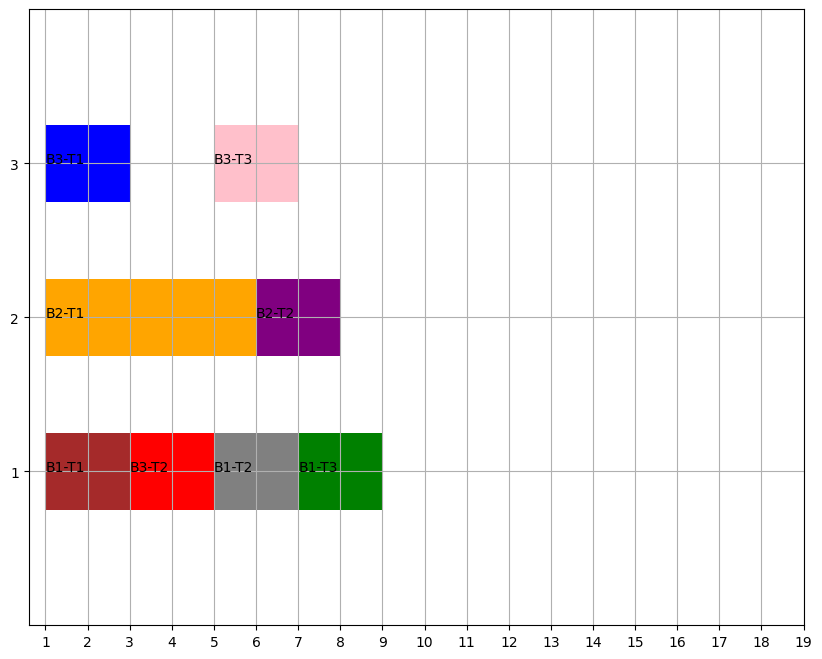

    machine   task  start  finish        Time Slot
0  machine1  B1-T1      1       3           [1, 2]
1  machine1  B1-T2      5       7           [5, 6]
2  machine1  B1-T3      7       9           [7, 8]
6  machine1  B3-T2      3       5           [3, 4]
3  machine2  B2-T1      1       6  [1, 2, 3, 4, 5]
4  machine2  B2-T2      6       8           [6, 7]
5  machine3  B3-T1      1       3           [1, 2]
7  machine3  B3-T3      5       7           [5, 6]
Status: Optimal
Optimal Value: 6.0


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul  7 07:08:39 2024

"""


import pickle
'''
with open('C:/Users/omid/Desktop/input_repr_dict.pkl', 'rb') as f:
  input_repr_dict = pickle.load(f)
  
J = input_repr_dict["J"]
M = input_repr_dict["M"]
compat = input_repr_dict["compat"]
'''

# First Example 
T = range(1, 25)  # Time horizon: 1 to 336
J = ['batch1', 'batch2']  # Example batch set
K = { 'batch1': [1, 2, 3], 'batch2': [1, 2, 3] }  # Example task sequences
compat= {'batch1': [["machine1"],["machine1"],["machine1"]] ,
         'batch2': [["machine2","machine3"],["machine2","machine3"],["machine2","machine3"]]}
M = { 1: ['machine1'], 2: ['machine2'], 3: ['machine3']}  # Example machine sets
d = { ('batch1', 1): 2, ('batch1', 2): 3, ('batch1', 3): 4,
      ('batch2', 1): 2, ('batch2', 2): 3, ('batch2', 3): 4 }  # Example durations
f = { 'batch1': 8, 'batch2': 8 }  # Example promised delivery times

# Second Example 
T = range(1, 20)  # Time horizon: 1 to 336
J = ['batch1', 'batch2', 'batch3']  # Example batch set
K = { 'batch1': [1, 2, 3], 'batch2': [1, 2] , 'batch3': [1, 2, 3] }  # Example task sequences
compat= {'batch1': [["machine1","machine2"],["machine1","machine2"],["machine1","machine2"]],
         'batch2': [["machine2","machine3"],["machine2","machine3"],["machine2","machine3"]],
         'batch3': [["machine1","machine3"],["machine1","machine3"],["machine1","machine3"]]}
compat= {'batch1': [["machine1"],["machine1"],["machine1"]],
         'batch2': [["machine1","machine2"],["machine1","machine2"],["machine1","machine2"]],
         'batch3': [["machine3","machine1"],["machine1"],["machine2","machine3"]]}
M = { 1: ['machine1'], 2: ['machine2'], 3: ['machine3']}  # Example machine sets
d = { ('batch1', 1): 2, ('batch1', 2): 2, ('batch1', 3): 2,
      ('batch2', 1): 5, ('batch2', 2): 2, 
      ('batch3', 1): 2, ('batch3', 2): 2, ('batch3', 3): 2}  # Example durations
f = { 'batch1': 10, 'batch2': 10 ,'batch3': 10 }  # Example promised delivery times

    
import pulp

print ("*************start to define Model **************")

# Variables

y = pulp.LpVariable.dicts("y", ((j, k, M[m][0], t) for j in J for k in K[j] for m in M for t in T if (M[m][0] in compat[j][k-1] and t <= len(T)- d[j, k]+1)), 0, 1, pulp.LpBinary)
x = pulp.LpVariable.dicts("x", ((j, k, M[m][0], t) for j in J for k in K[j] for m in M for t in T if M[m][0] in compat[j][k-1]), 0, 1, pulp.LpBinary)

# Problem definition
prob = pulp.LpProblem("SchedulingProblem", pulp.LpMaximize)

# -- Objective -- 
# Objective function: Minimize the starting times of tasks

prob.setObjective( sum(f[j] for j in J) - sum( (t+d[j, K[j][-1]]) * y[j, K[j][-1], M[m][0], t]  for j in J for m in M for t in T if (j, K[j][-1], M[m][0], t) in y.keys()))
# print(prob.objective)

 
# -- Constraints -- 
# Each task in each batch starts once and only on one machine
Cons1=[]

for j in J:
    for k in K[j]:
        Cons1.append(pulp.lpSum(y[j, k, M[m][0], t] for m in M for t in T if (j, k, M[m][0], t) in y.keys()) == 1)
        prob += Cons1[-1]

# A task only occupies a machine for the duration of processing time if the task is set to start on said machine
Cons2=[]
for j in J:
    for k in K[j]:
        for m in M:
            for t in T:
                if (j, k, M[m][0], t) in y.keys():
                    # Ensuring x values correspond correctly with the y start times
                    for t_prime in range(t, t + d[j, k]):
                        if (j, k, M[m][0], t_prime) in x.keys():
                            Cons2.append(x[j, k, M[m][0], t_prime] >= y[j, k, M[m][0], t])
                            prob += Cons2[-1]



# Total time the task occupies the machines equals the processing duration
Cons3=[]
for j in J:
    for k in K[j]:
        for m in M:
            if (j, k, M[m][0], t) in x.keys():
                Cons3.append(pulp.lpSum(x[j, k, M[m][0], t] for t in T) == d[j, k])
                prob+=Cons3[-1]
           
# Only one machine can be used at a time

Cons4=[]
for t in T:
    for m in M:
        Cons4.append(pulp.lpSum(x[j, k, M[m][0], t] for j in J for k in K[j] if (j, k, M[m][0], t) in x.keys()) <= 1)
        prob+=Cons4[-1]



# Tasks must be done in the order specified by the batch
Cons5=[]
for j in J:
    for k in K[j]:
        if  k!=K[j][-1] :
            kp=K[j].index(k)+1
            Cons5.append(pulp.lpSum(t*y[j, k, M[m][0], t] for m in M for t in T if (j, k, M[m][0], t) in y.keys()) + d[j, k] <=
                         pulp.lpSum(t * y[j, K[j][kp], M[m][0], t] for m in M for t in T if (j, K[j][kp], M[m][0], t) in y.keys()))

            prob+=Cons5[-1]
            

# Solve the problem
print ("*************Model Defined **************")
prob.solve()
# pulp.GUROBI(msg=1).solve(prob)
# prob.solve(pulp.GUROBI_CMD())


print("Status:", pulp.LpStatus[prob.status])

# Print the optimal value of the objective function
print("Optimal Value:", pulp.value(prob.objective))

# Print the results
# '''
for v in prob.variables():
    if v.varValue > 0.01: #and v.name.startswith('x') :
        print(f"{v.name} = {v.varValue}")
# '''
Data=[]

for v in prob.variables():
    if v.varValue > 0.01 and v.name.startswith('y') :
        v=v.name.split(",")
        Duration=d[(v[0].split("(")[1][1:-1],int(v[1][1:]))]
        Data.append([v[2][2:-1],f"B{v[0][-2]}-T{v[1][1:]}",int(v[3][1:-1]),int(v[3][1:-1])+Duration])
        Time_Slot=[]
        for vp in prob.variables():
            if vp.varValue > 0.01 and vp.name.startswith('x') :
                vp=vp.name.split(",")
                if (v[2][2:-1],v[0].split("(")[1][1:-1],int(v[1][1:]))==(vp[2][2:-1],vp[0].split("(")[1][1:-1],int(vp[1][1:])):
                    Time_Slot.append(int(vp[3][1:-1]))
        Data[-1].append(Time_Slot)
                
                
def Gant_Chart(Data):
    import pandas as pd
    mydata=pd.DataFrame(Data,columns=["machine","task" , "start" , "finish","Time Slot"])
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 8))
    
    AllColors=[]
    import matplotlib.colors as mcolors
    for i in mcolors.TABLEAU_COLORS.keys():
        AllColors.append(i[4:])
    # for i in mcolors.CSS4_COLORS.keys():
    #     AllColors.append(i)
    # import random
    # random.shuffle(AllColors)
        
    machines = set(list(mydata["machine"]))
    tasks = list(set(list(mydata["task"])))
    # orign = min(list(mydata["start"])) # time origin
    NM = len(machines) # Number of machines
    NM=max(list (int(i[-1]) for i in machines))
    for i in machines:
        # ymin = 0 # start y of gantt bar
        for index, row in mydata.iterrows():
            stdur = [] # list of tuples (start, duration)
            if row["machine"] == i:
                start = (row["start"])
                duration = (row["finish"] -  row["start"])
            
                stdur.append((start,duration))
                # print (stdur)
                # ax.annotate(row["task"], (start+duration/2,int(i[-1])))
                ax.annotate(row["task"], (start,int(i[-1])))
                ax.broken_barh(stdur, (int(i[-1])-0.25, 0.5), facecolors=(AllColors[tasks.index(row["task"])]))
           

    ax.set_ylim(0, NM+1)
    ax.set_yticks(range(1,NM+1))
    ax.set_xticks(T)
    # ax.set_yticklabels(machines)
    ax.grid(True)
    

    plt.show()
    return mydata

Data=Gant_Chart(Data)
Data=Data.sort_values("machine")
print(Data)
print("Status:", pulp.LpStatus[prob.status])
print("Optimal Value:", pulp.value(prob.objective))
